In [43]:
import torch
import torch.optim as optim
from models.attention import Attention
from matplotlib import pyplot as plt
from utils.helper import make_beta_schedule, EMA
from utils.plots import hdr_plot_style, plot_diffusion
hdr_plot_style()
from tqdm import tqdm
from ddpm import DDPM1d


In [44]:
device = torch.device("cuda:1") if torch.cuda.is_available() else "cpu"

In [45]:
device

device(type='cuda', index=1)

In [46]:
class config_pecan():
      n_steps = 500 # beta schedule steps
      input_dim = 96 # 
      hidden_dim = 1024
      nhead = 4 # nhead must be divided by hidden_dim
      cond_dim = 212
      epoch = 8000
      batch_size = 1024
      learning_rate = 2e-4
      ema_decay = 0.9
      beta_start = 1e-6
      beta_end = 2e-2
      loss_type='l2'

args = config_pecan()


# Dataset

In [47]:
loads = torch.load("./data/Pecan Street Smart Meter Data/loads.pt")
profile = torch.load("./data/Pecan Street Smart Meter Data/profile.pt")

# Sampling
loads = loads[:5]
profile = profile[:5]

dataset = torch.empty_like(loads)
for i in range(loads.shape[0]):
    load = loads[i]
    min_val = load.max()
    max_val = load.min()
    dataset[i] = 2 * (load - min_val) / (max_val - min_val) -1

dataset = dataset.reshape(-1, dataset.shape[-1])
cond = None
dataset.shape, dataset.mean(), dataset.var(), dataset.min(), dataset.max()

(torch.Size([140, 96]),
 tensor(0.2409),
 tensor(0.1193),
 tensor(-1.),
 tensor(1.))

In [48]:
loads.shape

torch.Size([5, 28, 96])

In [49]:
# Select betas
n_steps = args.n_steps

betas = make_beta_schedule(schedule='linear', n_timesteps=n_steps, start=args.beta_start, end=args.beta_end)
betas = betas.to(device)
model = Attention(args)
model = model.to(device)
dataset = dataset.to(device)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
ddpm = DDPM1d(model, betas, n_steps, (args.input_dim,), loss_type='l2')


# Create EMA model
ema = EMA(args.ema_decay)
ema.register(model)

Loss = []
for j in tqdm(range(args.epoch)):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], args.batch_size):
        # Retrieve current batch 
        indices = permutation[i:i+args.batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = ddpm(batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
        ddpm.model = model
    if j % 50 == 0:
        Loss.append(loss.item())
    if j%1000 == 0:
        print("loss: ", loss.item())
        torch.save(model, "./result/model_grid.pth")

/home/npg5/anaconda3/envs/hnn/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 1/8000 [00:00<17:34,  7.58it/s]

loss:  1.0405316352844238


 13%|█▎        | 1005/8000 [00:17<02:38, 44.21it/s]

loss:  0.14294621348381042


 25%|██▌       | 2005/8000 [00:33<02:15, 44.18it/s]

loss:  0.11760855466127396


 38%|███▊      | 3001/8000 [00:50<01:53, 44.18it/s]

loss:  0.13085447251796722


 50%|█████     | 4003/8000 [01:07<01:35, 41.93it/s]

loss:  0.12202497571706772


 63%|██████▎   | 5002/8000 [01:24<01:08, 43.81it/s]

loss:  0.10574738681316376


 75%|███████▌  | 6002/8000 [01:41<00:45, 43.82it/s]

loss:  0.09116572886705399


 88%|████████▊ | 7006/8000 [01:58<00:22, 43.79it/s]

loss:  0.08824823051691055


100%|██████████| 8000/8000 [02:14<00:00, 59.40it/s]


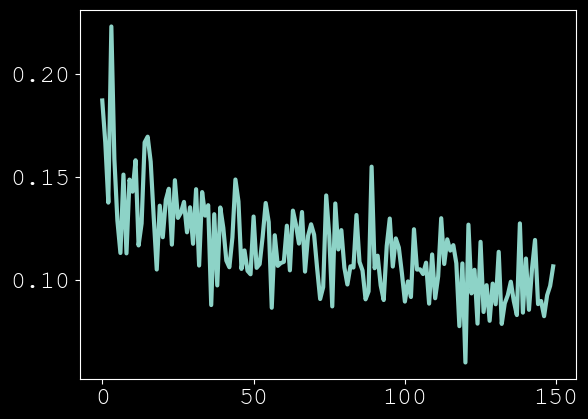

In [50]:
plt.plot(Loss[10:])

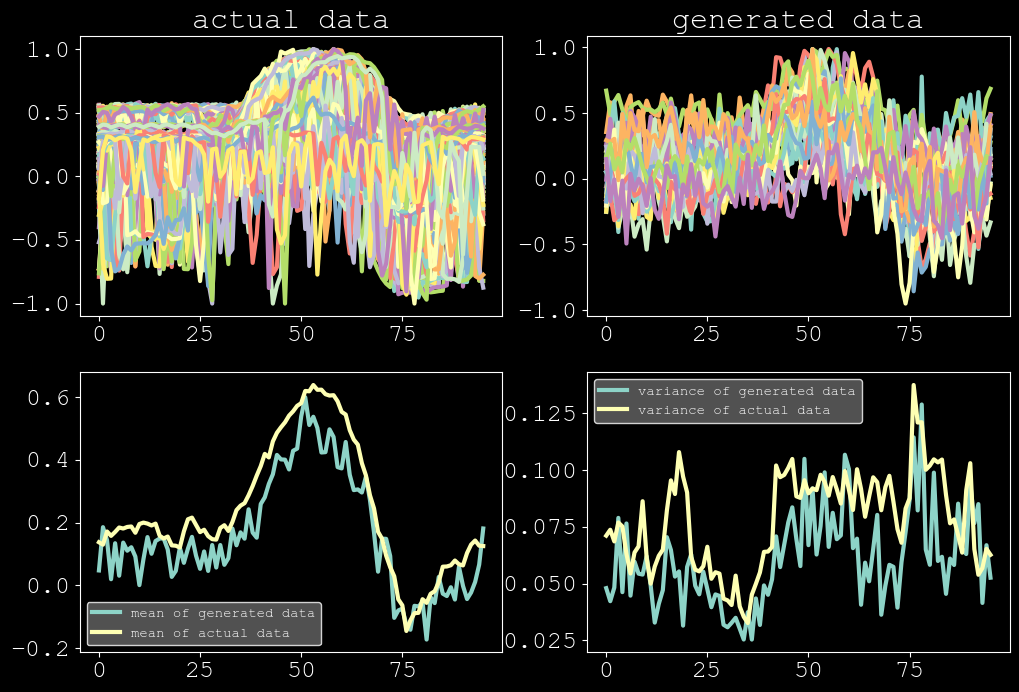

In [51]:

x_seq = ddpm.sample_seq(batch_size=28)

x_seq = x_seq.to("cpu")

test_data = dataset.to('cpu')
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
for i in range(len(test_data)):
    plt.plot(test_data[i])
plt.title("actual data")
plt.subplot(2,2,2)
for i in range(len(x_seq[-1])):
    plt.plot(x_seq[-1][i])
plt.title("generated data")
plt.subplot(2,2,3)
plt.plot(x_seq[-1].mean(dim=0), label = "mean of generated data")
plt.plot(test_data.mean(dim=0), label = "mean of actual data")
plt.legend(fontsize=10)
plt.subplot(2,2,4)
plt.plot(x_seq[-1].var(dim=0), label = "variance of generated data")
plt.plot(test_data.var(dim=0), label = "variance of actual data")
plt.legend(fontsize=10)